<a href="https://colab.research.google.com/github/Bhuvaneswarij/gitingest/blob/main/Time_series_LSTM()DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install -q numpy pandas scikit-learn tensorflow keras optuna shap matplotlib seaborn tqdm


In [5]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import optuna
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [6]:
print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


In [7]:
np.random.seed(42)
data_length = 500
data = np.sin(np.arange(data_length) * 0.1) + np.random.normal(0, 0.1, data_length)
df = pd.DataFrame(data, columns=["value"])
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (500, 1)


,value
0,0.049671
1,0.086007
2,0.263438
3,0.447823
4,0.366003


In [8]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df.values)

In [9]:
SEQ_LEN = 8

In [10]:
def create_sequences(data, seq_len=SEQ_LEN):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    return np.array(X), np.array(y)

In [11]:
X, y = create_sequences(scaled_data)
print("X shape:", X.shape, "y shape:", y.shape)


X shape: (492, 8, 1) y shape: (492, 1)


In [12]:
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]
print("Train shapes:", X_train.shape, y_train.shape)
print("Test shapes:", X_test.shape, y_test.shape)

Train shapes: (393, 8, 1) (393, 1)
Test shapes: (99, 8, 1) (99, 1)


In [13]:
def build_model(hidden_units=50, input_shape=(SEQ_LEN, X.shape[2])):
    model = Sequential()
    model.add(LSTM(hidden_units, input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

In [17]:
# ===============================
# SECTION 7: Hyperparameter Tuning with Optuna (Corrected)
# ===============================
def objective(trial):
    hidden_units = trial.suggest_int("hidden_units", 10, 100)
    lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)

    model = build_model(hidden_units=hidden_units)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='mse')
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

    loss = model.evaluate(X_test, y_test, verbose=0)
    return loss

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)
print("✅ Best Hyperparameters:", study.best_params)


[I 2025-12-06 13:20:28,946] A new study created in memory with name: no-name-6209a309-ba09-487d-9748-6d97bc1c55b1
/tmp/ipython-input-539712730.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2025-12-06 13:20:32,748] Trial 0 finished with value: 0.017031792551279068 and parameters: {'hidden_units': 86, 'lr': 0.00040093415445219873}. Best is trial 0 with value: 0.017031792551279068.
[I 2025-12-06 13:20:36,547] Trial 1 finished with value: 0.010430503636598587 and parameters: {'hidden_units': 46,

✅ Best Hyperparameters: {'hidden_units': 45, 'lr': 0.008845663135593014}


In [18]:
best_params = study.best_params
final_model = build_model(hidden_units=best_params['hidden_units'])
final_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_params['lr']), loss='mse')
final_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)


Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1126
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0169
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0106
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0100
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0079
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0056
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0037
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0025
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0035
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0029
Epoch 11/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0029
Epoch 12/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0029
Epoch 13/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0026
Epoch 14/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0027
Epoch 15/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0026
Epoch 16/50
13/13 ━

In [19]:
y_pred = final_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred) ** 0.5
print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step
MAE: 0.0431, RMSE: 0.0530


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


/tmp/ipython-input-178670063.py:14: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_train_flat[:10])
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:723: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(


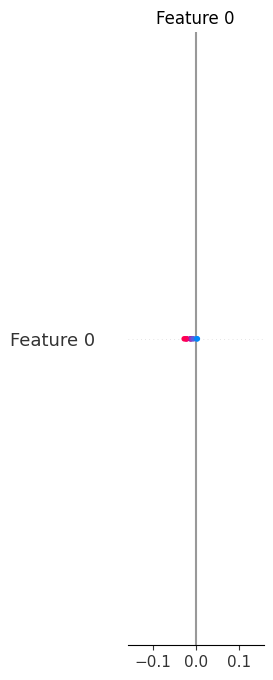

In [22]:
# Flatten sequences for SHAP
X_train_flat = X_train.reshape(X_train.shape[0], -1)

# Wrapper function to handle 3D input for LSTM
def model_predict_reshaped(X):
    X_reshaped = X.reshape(X.shape[0], SEQ_LEN, X.shape[1] // SEQ_LEN)
    return final_model.predict(X_reshaped)

# Create SHAP explainer using the wrapper
explainer = shap.KernelExplainer(model_predict_reshaped, X_train_flat[:100])
shap_values = explainer.shap_values(X_train_flat[:10])

# Plot SHAP summary
shap.summary_plot(shap_values, X_train_flat[:10])


In [23]:
# ===============================
# SECTION 11: Save Forecast Results
# ===============================

# Flatten y_test and y_pred to 1D if needed
y_test_flat = y_test.flatten()
y_pred_flat = y_pred.flatten()

# Create DataFrame
results = pd.DataFrame({
    'y_true': y_test_flat,
    'y_pred': y_pred_flat
})

# Save to CSV
results.to_csv("forecast_results.csv", index=False)
print("✅ Forecast results saved to forecast_results.csv")


✅ Forecast results saved to forecast_results.csv
